In [ ]:
#kashish sharma b30 e22cseu0890
# Install dependencies
!pip install opencv-python opencv-contrib-python matplotlib

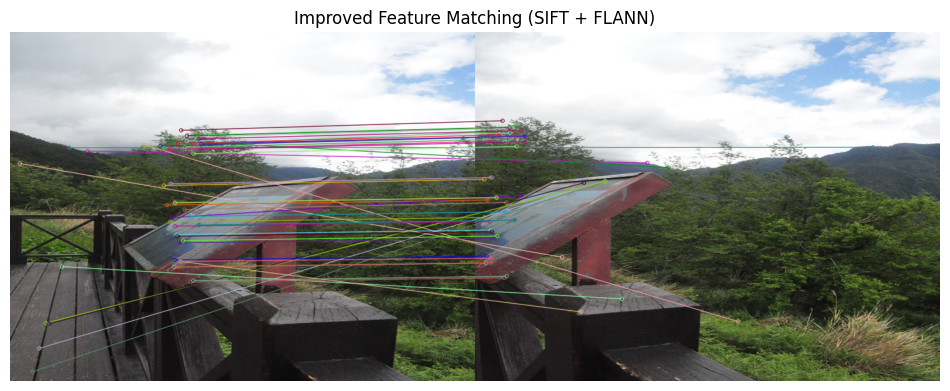

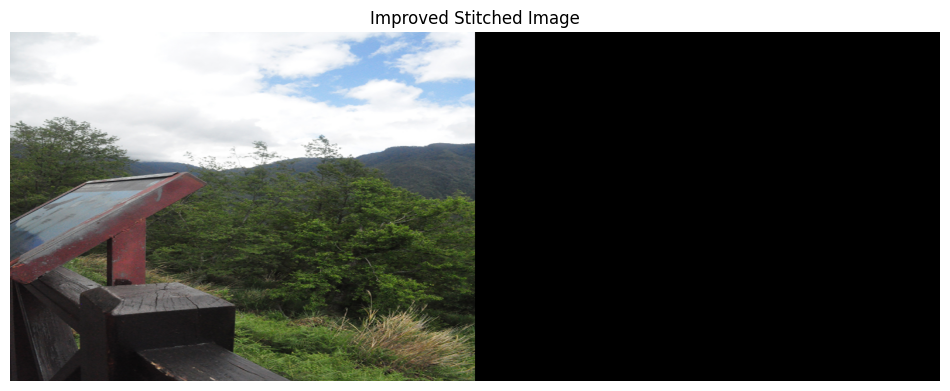

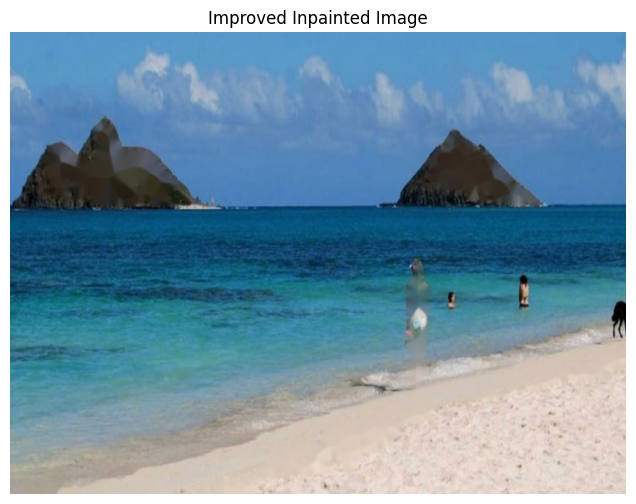

In [2]:
#TASK 1
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load and resize
img_left = cv2.imread("board1.jpg")
img_right = cv2.imread("board2.jpg")
img_noisy = cv2.imread("noisy_image.jpg")
img_left = cv2.resize(img_left, (800, 600))
img_right = cv2.resize(img_right, (800, 600))
img_noisy = cv2.resize(img_noisy, (800, 600))

# ========== Feature Matching (SIFT + FLANN) ==========
gray_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
gray_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)

sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(gray_left, None)
kp2, des2 = sift.detectAndCompute(gray_right, None)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1, des2, k=2)

# Apply Lowe's ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

img_matches = cv2.drawMatches(img_left, kp1, img_right, kp2, good_matches[:50], None, flags=2)

# ========== Homography + Stitching ==========
# ========== Improved Stitching ==========
src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# Warp left image
h1, w1 = img_left.shape[:2]
h2, w2 = img_right.shape[:2]
warp_img = cv2.warpPerspective(img_left, H, (w1 + w2, max(h1, h2)))

# Paste right image
warp_img[0:h2, 0:w2] = img_right

# Blend overlapping region (simple feathering)
overlap_start = w2 - 100  # adjust based on estimated overlap
for i in range(overlap_start, w2):
    alpha = (i - overlap_start) / 100.0
    warp_img[:, i] = cv2.addWeighted(img_right[:, i], 1 - alpha, warp_img[:, i], alpha, 0)

stitched_img = warp_img

# ========== Inpainting ==========
hsv = cv2.cvtColor(img_noisy, cv2.COLOR_BGR2HSV)
lower_skin = np.array([0, 40, 60], dtype=np.uint8)
upper_skin = np.array([25, 255, 255], dtype=np.uint8)
mask_skin = cv2.inRange(hsv, lower_skin, upper_skin)

# Morphological refining
kernel = np.ones((3, 3), np.uint8)
mask_refined = cv2.morphologyEx(mask_skin, cv2.MORPH_CLOSE, kernel)
mask_refined = cv2.dilate(mask_refined, kernel, iterations=1)

# Find largest contours (optional to avoid over-inpainting)
contours, _ = cv2.findContours(mask_refined, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for cnt in contours:
    area = cv2.contourArea(cnt)
    if area < 500:  # remove small false positives
        cv2.drawContours(mask_refined, [cnt], 0, 0, -1)

# Inpaint with Telea
inpainted_img = cv2.inpaint(img_noisy, mask_refined, 3, cv2.INPAINT_TELEA)

# ========== Display ==========
def show_img(img, title):
    plt.figure(figsize=(12, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

show_img(img_matches, "Improved Feature Matching (SIFT + FLANN)")
show_img(stitched_img, "Improved Stitched Image")
show_img(inpainted_img, "Improved Inpainted Image")


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,857 (38.50 KB)

 Trainable params: 9,857 (38.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.1217 - val_loss: 0.1140
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1121 - val_loss: 0.1140
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1119 - val_loss: 0.1140
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1118 - val_loss: 0.1140
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1118 - val_loss: 0.1140
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1121 - val_loss: 0.1140
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1120 - val_loss: 0.1140
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Avg PSNR: 10.411523


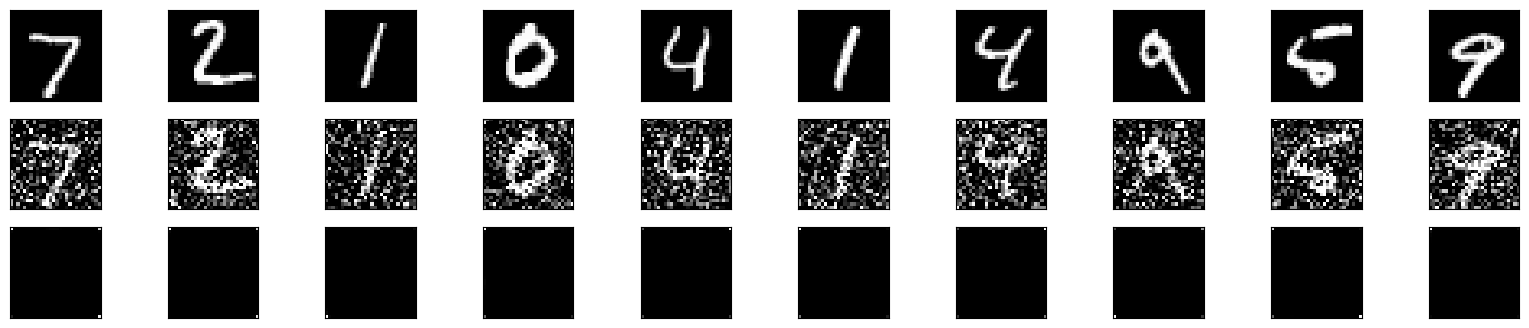


[INFO] Task 2 - Autoencoder Denoising Completed Successfully


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist

# -------- AUTOENCODER IMAGE RESTORATION --------
# Load and preprocess MNIST
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# Add Gaussian noise
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# Autoencoder architecture
input_img = layers.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = models.Model(input_img, x)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

# Train
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

# Predict
decoded_imgs = autoencoder.predict(x_test_noisy)

# PSNR Evaluation
def psnr(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 1.0
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

psnr_scores = [psnr(x_test[i], decoded_imgs[i]) for i in range(10)]
print("Avg PSNR:", np.mean(psnr_scores))

# Display original, noisy, and restored
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Noisy
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Denoised
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

print("\n[INFO] Task 2 - Autoencoder Denoising Completed Successfully")


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generator and Discriminator Classes (same as before)
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, 784)  # For MNIST (28x28 image)

    def forward(self, z):
        x = F.leaky_relu(self.fc1(z), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))

class Discriminator(nn.Module):
    def __init__(self, cifar=False):
        super(Discriminator, self).__init__()
        self.cifar = cifar
        if self.cifar:
            self.fc1 = nn.Linear(3072, 1024)  # 32x32x3 for CIFAR-10
        else:
            self.fc1 = nn.Linear(784, 1024)  # 28x28 for MNIST
        self.fc2 = nn.Linear(1024, 1)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the image
        x = F.leaky_relu(self.fc1(x), 0.2)
        return torch.sigmoid(self.fc2(x))

# Initialize the models and move them to the device
generator = Generator(z_dim=100).to(device)
discriminator = Discriminator(cifar=False).to(device)

# Optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training loop
def train_gan(dataloader):
    for epoch in range(10):
        for i, (real_images, _) in enumerate(dataloader):
            real_images = real_images.to(device)  # Move real images to the device

            # Training the Discriminator
            optimizer_d.zero_grad()

            # Train with real images
            output_real = discriminator(real_images)
            real_labels = torch.ones(real_images.size(0), 1).to(device)
            d_loss_real = F.binary_cross_entropy(output_real, real_labels)

            # Train with fake images
            z = torch.randn(real_images.size(0), 100).to(device)  # Random noise for generator
            fake_images = generator(z)
            output_fake = discriminator(fake_images.detach())
            fake_labels = torch.zeros(real_images.size(0), 1).to(device)
            d_loss_fake = F.binary_cross_entropy(output_fake, fake_labels)

            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            optimizer_d.step()

            # Training the Generator
            optimizer_g.zero_grad()

            output_fake = discriminator(fake_images)
            g_loss = F.binary_cross_entropy(output_fake, real_labels)
            g_loss.backward()
            optimizer_g.step()

            if i % 100 == 0:
                print(f"Epoch [{epoch}/{10}], Step [{i}/{len(dataloader)}], "
                      f"D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

# Example dataloader for MNIST (modify according to your dataset)
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataloader = torch.utils.data.DataLoader(datasets.MNIST('.', download=True, train=True, transform=transform),
                                         batch_size=64, shuffle=True)

# Train GAN
train_gan(dataloader)


Epoch [0/10], Step [0/938], D Loss: 1.3334747552871704, G Loss: 0.6917543411254883
Epoch [0/10], Step [100/938], D Loss: 1.3098020553588867, G Loss: 0.7082422971725464
Epoch [0/10], Step [200/938], D Loss: 1.3172026872634888, G Loss: 0.782221257686615
Epoch [0/10], Step [300/938], D Loss: 1.115954875946045, G Loss: 0.8115241527557373
Epoch [0/10], Step [400/938], D Loss: 0.9749845266342163, G Loss: 0.9256875514984131
Epoch [0/10], Step [500/938], D Loss: 1.0737181901931763, G Loss: 1.1212036609649658
Epoch [0/10], Step [600/938], D Loss: 1.265795111656189, G Loss: 0.8115260004997253
Epoch [0/10], Step [700/938], D Loss: 0.9522687196731567, G Loss: 1.2706218957901
Epoch [0/10], Step [800/938], D Loss: 1.2268853187561035, G Loss: 0.9436668753623962
Epoch [0/10], Step [900/938], D Loss: 0.9244235754013062, G Loss: 1.4441149234771729
Epoch [1/10], Step [0/938], D Loss: 0.9578720331192017, G Loss: 1.5027554035186768
Epoch [1/10], Step [100/938], D Loss: 0.8238582015037537, G Loss: 1.4044588

Epoch [0/10], Step [0/938], D Loss: 1.341261863708496, G Loss: 0.6988449096679688
Epoch [0/10], Step [100/938], D Loss: 1.379551649093628, G Loss: 0.7280048131942749
Epoch [0/10], Step [200/938], D Loss: 1.3327529430389404, G Loss: 0.7933392524719238
Epoch [0/10], Step [300/938], D Loss: 1.2307108640670776, G Loss: 0.7849514484405518
Epoch [0/10], Step [400/938], D Loss: 1.0537842512130737, G Loss: 0.7904109358787537
Epoch [0/10], Step [500/938], D Loss: 1.1800447702407837, G Loss: 1.0965172052383423
Epoch [0/10], Step [600/938], D Loss: 1.1668908596038818, G Loss: 0.9943570494651794
Epoch [0/10], Step [700/938], D Loss: 1.1170692443847656, G Loss: 1.2537312507629395
Epoch [0/10], Step [800/938], D Loss: 1.0697932243347168, G Loss: 1.2349824905395508
Epoch [0/10], Step [900/938], D Loss: 1.0405845642089844, G Loss: 1.327089548110962
Epoch [1/10], Step [0/938], D Loss: 0.9695389270782471, G Loss: 1.2775001525878906
Epoch [1/10], Step [100/938], D Loss: 1.1017651557922363, G Loss: 1.4785

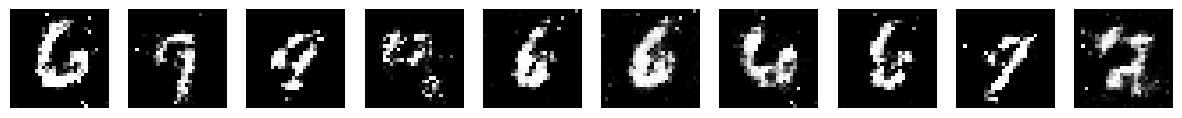

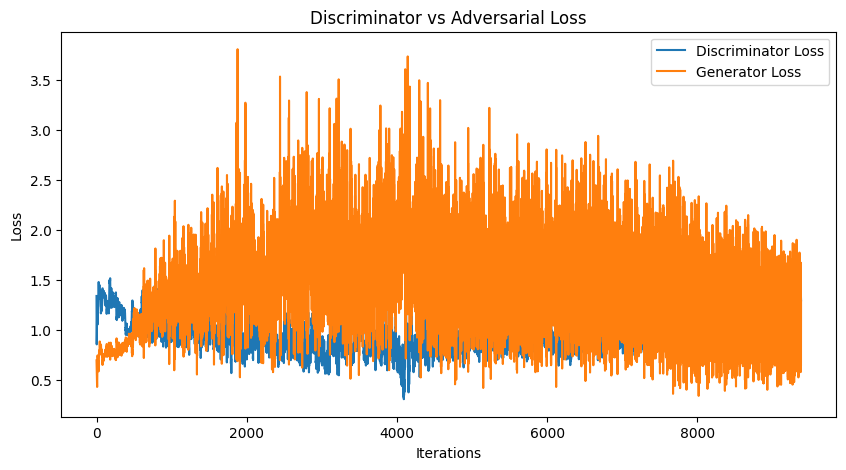

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generator and Discriminator Classes
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, 784)  # For MNIST (28x28 image)

    def forward(self, z):
        x = F.leaky_relu(self.fc1(z), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))

class Discriminator(nn.Module):
    def __init__(self, cifar=False):
        super(Discriminator, self).__init__()
        self.cifar = cifar
        if self.cifar:
            self.fc1 = nn.Linear(3072, 1024)  # 32x32x3 for CIFAR-10
        else:
            self.fc1 = nn.Linear(784, 1024)  # 28x28 for MNIST
        self.fc2 = nn.Linear(1024, 1)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the image
        x = F.leaky_relu(self.fc1(x), 0.2)
        return torch.sigmoid(self.fc2(x))

# Initialize the models and move them to the device
z_dim = 100
generator = Generator(z_dim=z_dim).to(device)
discriminator = Discriminator(cifar=False).to(device)

# Optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Track losses
d_losses = []
g_losses = []

# Training loop
def train_gan(dataloader, num_epochs=10):
    for epoch in range(num_epochs):
        for i, (real_images, _) in enumerate(dataloader):
            real_images = real_images.to(device)  # Move real images to the device

            # Training the Discriminator
            optimizer_d.zero_grad()

            # Train with real images
            output_real = discriminator(real_images)
            real_labels = torch.ones(real_images.size(0), 1).to(device)
            d_loss_real = F.binary_cross_entropy(output_real, real_labels)

            # Train with fake images
            z = torch.randn(real_images.size(0), z_dim).to(device)  # Random noise for generator
            fake_images = generator(z)
            output_fake = discriminator(fake_images.detach())
            fake_labels = torch.zeros(real_images.size(0), 1).to(device)
            d_loss_fake = F.binary_cross_entropy(output_fake, fake_labels)

            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            optimizer_d.step()

            # Training the Generator
            optimizer_g.zero_grad()

            output_fake = discriminator(fake_images)
            g_loss = F.binary_cross_entropy(output_fake, real_labels)
            g_loss.backward()
            optimizer_g.step()

            # Track losses
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())

            if i % 100 == 0:
                print(f"Epoch [{epoch}/{num_epochs}], Step [{i}/{len(dataloader)}], "
                      f"D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

# Example dataloader for MNIST
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataloader = torch.utils.data.DataLoader(datasets.MNIST('.', download=True, train=True, transform=transform),
                                         batch_size=64, shuffle=True)

# Train GAN
train_gan(dataloader)

# Generate 10 different MNIST digits
z = torch.randn(10, z_dim).to(device)
generated_images = generator(z)

# Convert the generated images from tensor to numpy array
generated_images = generated_images.view(10, 28, 28).cpu().detach().numpy()

# Plot generated digits
fig, axes = plt.subplots(1, 10, figsize=(15, 3))
for i in range(10):
    axes[i].imshow(generated_images[i], cmap='gray')
    axes[i].axis('off')
plt.show()

# Plot discriminator vs adversarial loss
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.title('Discriminator vs Adversarial Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()


Epoch [0/5], Step [0/782], D Loss: 1.3529596328735352, G Loss: 0.6998833417892456
Epoch [0/5], Step [100/782], D Loss: 0.737780749797821, G Loss: 0.8764846920967102
Epoch [0/5], Step [200/782], D Loss: 0.8292984366416931, G Loss: 0.9418352246284485
Epoch [0/5], Step [300/782], D Loss: 0.7375765442848206, G Loss: 1.1877871751785278
Epoch [0/5], Step [400/782], D Loss: 0.8704646825790405, G Loss: 1.3448481559753418
Epoch [0/5], Step [500/782], D Loss: 0.9122093319892883, G Loss: 1.5093400478363037
Epoch [0/5], Step [600/782], D Loss: 0.5446739196777344, G Loss: 2.084045171737671
Epoch [0/5], Step [700/782], D Loss: 0.8330404758453369, G Loss: 1.5605823993682861
Epoch [1/5], Step [0/782], D Loss: 0.9351931810379028, G Loss: 1.66465425491333
Epoch [1/5], Step [100/782], D Loss: 1.2608221769332886, G Loss: 1.4944887161254883
Epoch [1/5], Step [200/782], D Loss: 0.7570852041244507, G Loss: 1.8832907676696777
Epoch [1/5], Step [300/782], D Loss: 1.813617467880249, G Loss: 3.254261016845703
Ep

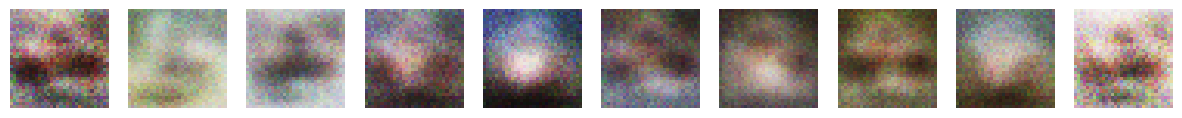

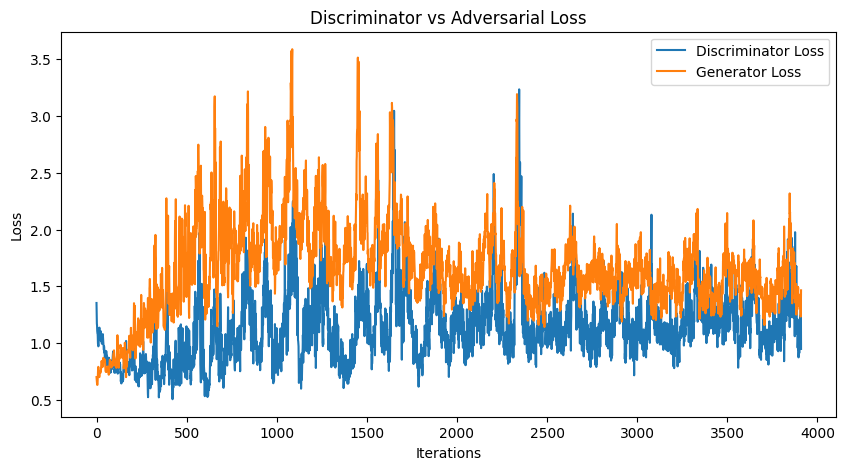

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generator and Discriminator Classes
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, 3072)  # For CIFAR-10 (32x32x3 = 3072)

    def forward(self, z):
        x = F.leaky_relu(self.fc1(z), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x)).view(-1, 3, 32, 32)  # Output 32x32x3 images

class Discriminator(nn.Module):
    def __init__(self, cifar=True):
        super(Discriminator, self).__init__()
        self.cifar = cifar
        if self.cifar:
            self.fc1 = nn.Linear(3072, 1024)  # 32x32x3 for CIFAR-10
        else:
            self.fc1 = nn.Linear(784, 1024)  # 28x28 for MNIST
        self.fc2 = nn.Linear(1024, 1)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the image
        x = F.leaky_relu(self.fc1(x), 0.2)
        return torch.sigmoid(self.fc2(x))

# Initialize the models and move them to the device
z_dim = 100
generator = Generator(z_dim=z_dim).to(device)
discriminator = Discriminator(cifar=True).to(device)

# Optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Track losses
d_losses = []
g_losses = []

# Training loop
def train_gan(dataloader, num_epochs=5):
    for epoch in range(num_epochs):
        for i, (real_images, _) in enumerate(dataloader):
            real_images = real_images.to(device)  # Move real images to the device

            # Training the Discriminator
            optimizer_d.zero_grad()

            # Train with real images
            output_real = discriminator(real_images)
            real_labels = torch.ones(real_images.size(0), 1).to(device)
            d_loss_real = F.binary_cross_entropy(output_real, real_labels)

            # Train with fake images
            z = torch.randn(real_images.size(0), z_dim).to(device)  # Random noise for generator
            fake_images = generator(z)
            output_fake = discriminator(fake_images.detach())
            fake_labels = torch.zeros(real_images.size(0), 1).to(device)
            d_loss_fake = F.binary_cross_entropy(output_fake, fake_labels)

            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            optimizer_d.step()

            # Training the Generator
            optimizer_g.zero_grad()

            output_fake = discriminator(fake_images)
            g_loss = F.binary_cross_entropy(output_fake, real_labels)
            g_loss.backward()
            optimizer_g.step()

            # Track losses
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())

            if i % 100 == 0:
                print(f"Epoch [{epoch}/{num_epochs}], Step [{i}/{len(dataloader)}], "
                      f"D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

# Example dataloader for CIFAR-10
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataloader = torch.utils.data.DataLoader(datasets.CIFAR10('.', download=True, train=True, transform=transform),
                                         batch_size=64, shuffle=True)

# Train GAN
train_gan(dataloader)

# Generate 10 different CIFAR-10 images
z = torch.randn(10, z_dim).to(device)
generated_images = generator(z)

# Convert the generated images from tensor to numpy array
generated_images = generated_images.cpu().detach().numpy()

# Plot generated images
fig, axes = plt.subplots(1, 10, figsize=(15, 3))
for i in range(10):
    axes[i].imshow((generated_images[i].transpose(1, 2, 0) + 1) / 2)  # Rescale image
    axes[i].axis('off')
plt.show()

# Plot discriminator vs adversarial loss
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.title('Discriminator vs Adversarial Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()
